In [400]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as vdatasets
import torchvision.utils as vutils
import random
from tensorboardX import SummaryWriter
torch.manual_seed(1)

USE_CUDA = torch.cuda.is_available()

import matplotlib.pyplot as plt
%matplotlib inline

### FashionMNIST 

In [12]:
train_dataset = vdatasets.FashionMNIST(root='../data/FM/',
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True,
                                           num_workers=2)

test_dataset = vdatasets.FashionMNIST(root='../data/FM/',
                               train=False, 
                               transform=transforms.ToTensor(),
                               download=True)


test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=64, 
                                           shuffle=True,
                                           num_workers=2)

Processing...
Done!


In [13]:
print(train_dataset[0][0].size(),train_dataset[0][1])

torch.Size([1, 28, 28]) 9


In [20]:
# for i in range(9):
#     plt.subplot(3,3,i+1)
#     plt.imshow(train_dataset[i][0].squeeze(0).numpy(), cmap='gray', interpolation='none')
#     plt.title("Class {}".format(train_dataset[i][1]))

In [412]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(1,16,5,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,return_indices=True)
            )
        
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(16,32,5,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,return_indices=True)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(32*7*7,128),
            nn.ReLU(),
            nn.Linear(128,10)
        )
    
        self.deconv = nn.ConvTranspose2d(1,1,5,padding=2)
        self.unpooling = nn.MaxUnpool2d(2)

    
    def visualize_layer(self,inputs,layer=None):
        inputs,indices1 = self.conv_layer1(inputs)
        
        index = random.choice(range(inputs.size(1)))
        featuremap = inputs[0][index].view(1,1,inputs.size(2),inputs.size(3))
        f_indices = indices1[0][index].view(1,1,inputs.size(2),inputs.size(3))
        unpooled = self.unpooling(featuremap,f_indices)
        unpooled = F.relu(unpooled)
        
        # 해당 필터 weight 복사
        self.deconv.weight.data = self.conv_layer1[0].weight.data[index].unsqueeze(0).clone()
        
        deconved1 = self.deconv(unpooled)
        return deconved1
        
    def forward(self,inputs):
        inputs,_ = self.conv_layer1(inputs)
        inputs,_ = self.conv_layer2(inputs)
        
        return self.fc(inputs.view(inputs.size(0),-1))
        

In [413]:
EPOCH=3
LR=0.01
BATCH_SIZE=64

model = CNN()
loss_function = nn.CrossEntropyLoss() # 소프트맥스 함수 포함하고 있음
optimizer = optim.Adam(model.parameters(), lr=LR)

In [414]:
for epoch in range(EPOCH):
    losses=[]
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = Variable(inputs), Variable(targets)
        model.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        losses.append(loss.data[0])
        if i % 100 == 0:
            print("[%d/%d] [%03d/%d] mean_loss : %.3f" % (epoch,EPOCH,i,len(train_loader),np.mean(losses)))
            losses=[]

[0/3] [000/938] mean_loss : 2.304
[0/3] [100/938] mean_loss : 0.792
[0/3] [200/938] mean_loss : 0.467
[0/3] [300/938] mean_loss : 0.415
[0/3] [400/938] mean_loss : 0.379
[0/3] [500/938] mean_loss : 0.364
[0/3] [600/938] mean_loss : 0.361
[0/3] [700/938] mean_loss : 0.353
[0/3] [800/938] mean_loss : 0.349
[0/3] [900/938] mean_loss : 0.335
[1/3] [000/938] mean_loss : 0.326
[1/3] [100/938] mean_loss : 0.318
[1/3] [200/938] mean_loss : 0.311
[1/3] [300/938] mean_loss : 0.310
[1/3] [400/938] mean_loss : 0.321
[1/3] [500/938] mean_loss : 0.314
[1/3] [600/938] mean_loss : 0.323
[1/3] [700/938] mean_loss : 0.313
[1/3] [800/938] mean_loss : 0.321
[1/3] [900/938] mean_loss : 0.311
[2/3] [000/938] mean_loss : 0.419
[2/3] [100/938] mean_loss : 0.285
[2/3] [200/938] mean_loss : 0.299
[2/3] [300/938] mean_loss : 0.307
[2/3] [400/938] mean_loss : 0.308
[2/3] [500/938] mean_loss : 0.301
[2/3] [600/938] mean_loss : 0.306
[2/3] [700/938] mean_loss : 0.273
[2/3] [800/938] mean_loss : 0.306
[2/3] [900/938

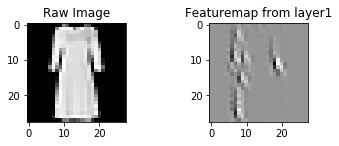

In [417]:
input = random.choice(test_dataset)

plt.subplot(2,2,1)
plt.imshow(input[0].squeeze().numpy(), cmap='gray', interpolation='none')
plt.title("Raw Image")

feature = model.visualize_layer(Variable(input[0].unsqueeze(0)))

plt.subplot(2,2,2)
plt.imshow(feature.squeeze().data.numpy(), cmap='gray', interpolation='none')
plt.title("Featuremap from layer1")

* 웨이트 순으로 정렬 후, 탑 9개만 보여주기
* 레이어별로 보여주기
* CIFAR-10 적용